In [23]:
# data manipulation 
import numpy as np
import pandas as pd



from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from fbprophet import Prophet
%matplotlib inline
pd.plotting.register_matplotlib_converters()

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire
import prep
from model import next_two_weeks_Holt

SyntaxError: invalid syntax (model.py, line 46)

In [16]:
#Needed Functions
    #1. Evaluate()- will compute the Mean Squared Error and the Rood Mean Squared Error
    #2. plot_and_eval()- will use evaluate function and plot a comparison of train and test 

def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

#### Acquire and prep
consolidate all the csv files, delete the nutrition related data.

In [17]:
#consolidate all the csv files of fitbit data
df= acquire.get_df()
#Clean data: format date, format other columns for predicitons
df= prep.prep_df()
target_vars=['Steps', 'Calories Burned', 'Activity Calories']
df.head()

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


Target Variables:
    Steps
    Calories Burned
    Activity Calories

#### Split Data 

In [18]:
#split data for train and test, using 66% of the data for a train and 33% for test
train, test= prep.test_train_split(df, .66)
print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 148
Testing Observations: 77


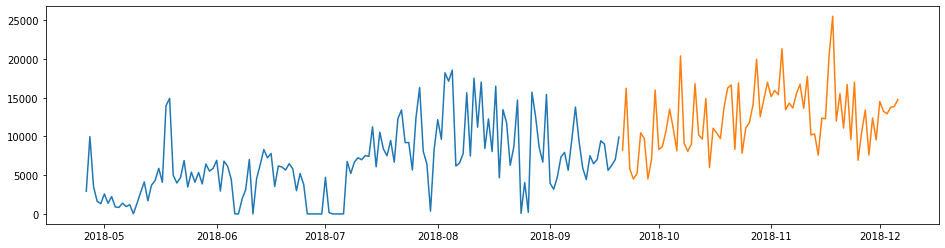

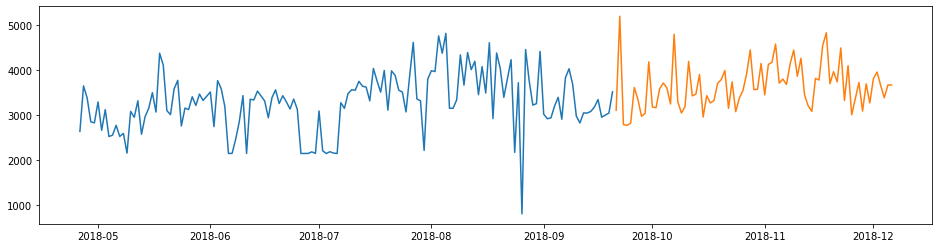

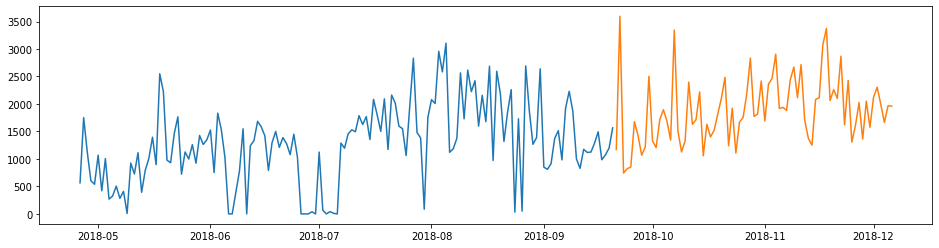

In [19]:
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

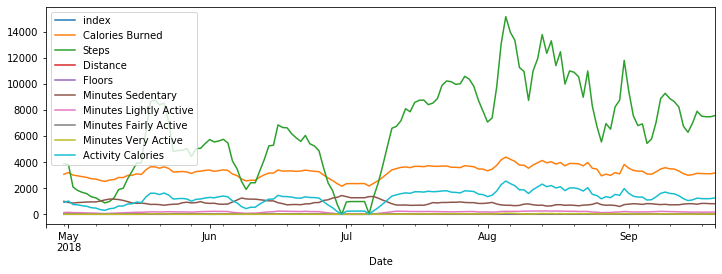

In [20]:
### Moving Average
train.rolling(5).mean().plot(figsize=(12, 4))
plt.show()

#### Simple Average- 
Used as our baseline to compare with our predictions

In [21]:
for var in target_vars:
    yhat[var] = train[var].mean()
yhat.head()

,Steps,Calories Burned,Activity Calories
Date,,,
2018-09-21,6482.236486,3271.871622,1273.0
2018-09-22,6482.236486,3271.871622,1273.0
2018-09-23,6482.236486,3271.871622,1273.0
2018-09-24,6482.236486,3271.871622,1273.0
2018-09-25,6482.236486,3271.871622,1273.0


Steps -- MSE: 53133261.42 RMSE: 7289.26
Calories Burned -- MSE: 398966.03 RMSE: 631.64
Activity Calories -- MSE: 742610.47 RMSE: 861.75


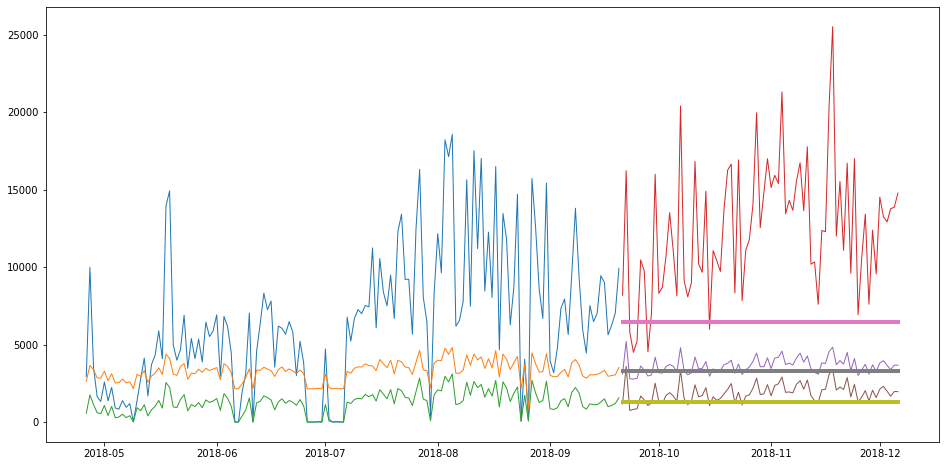

In [22]:
plot_and_eval(target_vars, train = train, test = test)